In [4]:
import numpy as np
import pandas as pd
from scipy.stats import mstats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pystan
import arviz
from scipy import linalg

In [5]:
def createData(d,dl,n,mu,sigma2):
    # sample latent variable Z
    Z = np.random.multivariate_normal(np.zeros(dl),np.identity(dl),n).T  # dl x n
    # create orthogonal signal directions
    W = linalg.orth(np.random.random((d,dl)))  # d x dl
    # create additive noise
    noise = np.random.multivariate_normal(np.zeros(d),sigma2*np.identity(d),n).T  # d x n
    
    # data-space data
    Y = np.dot(W,Z) + noise;
    
    return dict(Y=Y,W=W,Z=Z)

In [10]:
d=2     # data space dimensions
dl=1    # latent space dimensions
mu = np.zeros(d)
sigma2 = 0.05
n=500
data = createData(d,dl,n,mu,sigma2)
W = data['W']
Y = data['Y']
Z = data['Z']

In [7]:
stan_model = """
data {
  int<lower=1> N;              // num datapoints
  int<lower=1> D;              // num data-space dimensions
  int<lower=1> K;              // num latent space dimensions
  real<lower=0> ones;
  real y[D,N];
}
transformed data {
  matrix[K,K] Sigma;                  // identity matrix
  vector<lower=0>[K] diag_elem;
  vector<lower=0>[K] zr_vec;          // zero vector
  for (k in 1:K) zr_vec[k] <- 0;
  for (k in 1:K) diag_elem[k] <- ones;
  Sigma <- diag_matrix(diag_elem);
}
parameters {
  matrix[D,K] A;            // transformation matrix / PCs
  vector[K] x[N];           // latent variables
  real<lower=0> sigma;      // noise variance
}
model {  
  
  for (i in 1:N)
      x[i] ~ multi_normal(zr_vec, Sigma);     // zero-mean, identity matrix
  for (i in 1:N)
    for (d in 1:D)
      //y[d,i] ~ normal(dot_product(row(A, d), x[i]), sigma);
      increment_log_prob(normal_log(y[d,i], dot_product(row(A, d), x[i]), sigma));           
}
generated quantities {
    vector[N] log_lik;
    for (n in 1:N)
       for (d in 1:D)
        log_lik[n] <- normal_log(y[d,n], dot_product(row(A, d), x[n]), sigma);
}
"""

In [8]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a213df6c2be095068d5c5c48a42604e6 NOW.


In [11]:
stan_data = {
    'N': n, 
    'D': d, 
    'K': dl,
    'ones': 1,
    'y': Y
}
fit = sm.sampling(data=stan_data, iter=2000, warmup=500, chains=3, seed=123)
print(fit)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_a213df6c2be095068d5c5c48a42604e6.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

                mean se_mean     sd   2.5%     25%     50%    75%  97.5%  n_eff   Rhat
A[1,1]         -0.23    0.54   0.66  -0.75   -0.71   -0.69   0.68   0.74      2  29.06
A[2,1]         -0.22    0.51   0.63  -0.71   -0.67   -0.65   0.65    0.7      2   28.8
x[1,1]         -0.56    1.31   1.61  -2.11   -1.76   -1.53   1.54    2.0      2   7.64
x[2,1]         -0.15    0.36   0.49  -0.88   -0.53   -0.31    0.3   0.78      2   2.29
x[3,1]          0.41    0.95   1.18  -1.58   -1.07    1.08   1.29   1.65      2   5.52
x[4,1]          0.18    0.43   0.57  -0.89    -0.4    0.39   0.61   0.95      2   2.66
x[5,1]          -0.3    0.71   0.89  -1.32   -0.98   -0.74   0.76   1.25      2   4.16
x[6,1]          0.56     1.3   1.61  -2.02   -1.54    1.53   1.76   2.11      2   7.61
x[7,1]          0.69    1.61 

In [13]:
samples = fit.extract(permuted=True)
A = samples['A']
A = A[:,:,0]
W_est = np.mean(abs(A.T),1)[np.newaxis]   
# newaxis becuase the mean of A is just a 1D array and in Python this cannot be transposed
W_est = linalg.orth(W_est.T)

In [14]:
S = np.sign(samples['A'])
np.unique(S[:,0]*S[:,1])

array([1.])

In [15]:
print('The estimated weights are W=[{:f}, {:f}]\n'.format(W_est[0,0],W_est[1,0]))
print('The true weights are W=[{:f}, {:f}]\n'.format(W[0,0],W[1,0]))

The estimated weights are W=[0.725468, 0.688256]

The true weights are W=[0.716670, 0.697412]



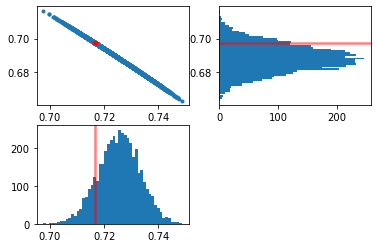

In [16]:
orth_A = np.zeros(A.shape) # initialize empty matrix to hold orthonormalized samples for A

for i in range(0,len(A)):
    orth_A[i,:] = linalg.orth(abs(A[i,:])[np.newaxis].T).T
    

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.plot(orth_A[:,0],orth_A[:,1],'.')
ax1.plot(W[0],W[1],'r*')
axes = plt.gca()

ax2 = fig.add_subplot(222)
ax2.hist(orth_A[:,1],50,orientation='horizontal')
ax2.axhline(W[1], color='#ff0000', linewidth=2.5, alpha=0.5)

ax3 = fig.add_subplot(223)
ax3.hist(orth_A[:,0],50)
ax3.axvline(W[0], color='#ff0000', linewidth=2.5, alpha=0.5);

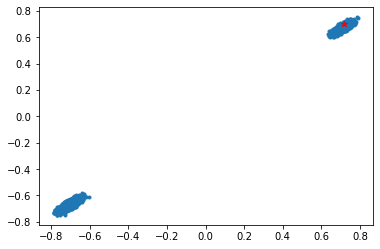

In [17]:
# original samples without orthonormalization
plt.plot(A[:,0],A[:,1],'.')
plt.plot(W[0],W[1],'r*');